<a href="https://colab.research.google.com/github/AkhileshSurampalli/master/blob/master/Model_Considered(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import os

from google.colab import drive
drive.mount('/content/drive')

file_path = r"/content/drive/My Drive/Project_folder/result_df.csv"

df = pd.read_csv(file_path)


print(f"the shape of the final dataframe is : {df.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
the shape of the final dataframe is : (234060, 46)


In [9]:
from sklearn.preprocessing import StandardScaler
columns = ['acc_x/atr01', 'acc_y/atr01', 'acc_z/atr01',
       'gyro_x/atr01', 'gyro_y/atr01', 'gyro_z/atr01', 'quat_w/atr01',
       'quat_x/atr01', 'quat_y/atr01', 'quat_z/atr01', 'acc_x/atr02',
       'acc_y/atr02', 'acc_z/atr02', 'gyro_x/atr02', 'gyro_y/atr02',
       'gyro_z/atr02', 'quat_w/atr02', 'quat_x/atr02', 'quat_y/atr02',
       'quat_z/atr02', 'acc_x/atr03', 'acc_y/atr03', 'acc_z/atr03',
       'gyro_x/atr03', 'gyro_y/atr03', 'gyro_z/atr03', 'quat_w/atr03',
       'quat_x/atr03', 'quat_y/atr03', 'quat_z/atr03', 'acc_x/atr04',
       'acc_y/atr04', 'acc_z/atr04', 'gyro_x/atr04', 'gyro_y/atr04',
       'gyro_z/atr04', 'quat_w/atr04', 'quat_x/atr04', 'quat_y/atr04',
       'quat_z/atr04']

scaler = StandardScaler()
df[columns] = scaler.fit_transform(df[columns])


df.head()

,Unnamed: 0,acc_x/atr01,acc_y/atr01,acc_z/atr01,gyro_x/atr01,gyro_y/atr01,gyro_z/atr01,quat_w/atr01,quat_x/atr01,quat_y/atr01,...,gyro_z/atr04,quat_w/atr04,quat_x/atr04,quat_y/atr04,quat_z/atr04,unixtime,operation,operation_id,operation_box,action
0,0,-1.190620,1.595211,-0.387479,-0.082999,1.298355,0.151137,0.0,0.0,0.0,...,0.484616,0.0,0.0,0.0,0.0,1634178749767,Picking,100,5,Pick Up Sheet
1,1,-0.100894,0.508560,-0.742268,0.332788,-1.273309,0.380806,0.0,0.0,0.0,...,-0.170497,0.0,0.0,0.0,0.0,1634178752712,Picking,100,5,Walk to Work Bench
2,2,0.598081,0.539289,-1.030896,0.223445,-0.346433,0.101873,0.0,0.0,0.0,...,-0.150472,0.0,0.0,0.0,0.0,1634178752737,Picking,100,5,Walk to Work Bench
3,3,0.136633,0.596967,-0.949642,0.237310,0.434771,0.004559,0.0,0.0,0.0,...,-0.135215,0.0,0.0,0.0,0.0,1634178752762,Picking,100,5,Walk to Work Bench
4,4,0.005298,0.705467,-0.983963,0.316992,0.247406,-0.091021,0.0,0.0,0.0,...,-0.187026,0.0,0.0,0.0,0.0,1634178752787,Picking,100,5,Walk to Work Bench


In [10]:
df = df.drop(columns=['Unnamed: 0'], axis=1)

In [11]:
from scipy.stats import mode

def sliding_window(data, window_size, step_size):

    n_samples, n_features = data.shape
    windows = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])

    return np.array(windows)

#Create windows for non-numerical data
def sliding_window_non_numerical(data, window_size, step_size):
    windows = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

# Extracting numerical data (drop non-numerical data)
X_raw = df.drop(['operation', 'unixtime', 'action', 'operation_id', 'operation_box'], axis=1).values

#Extracting non-numerical data
unixtime_raw = df['unixtime'].values
actions_raw = df['action'].values
operation_raw = df['operation'].values
# Window parameters
window_size = 100
step_size = 50

# Sliding windows for numeric data
X_windows = sliding_window(X_raw, window_size, step_size)

# Sliding windows for non-numeric data
unixtime_windows = sliding_window_non_numerical(unixtime_raw, window_size, step_size)
actions_windows = sliding_window_non_numerical(actions_raw, window_size, step_size)
operation_windows = sliding_window_non_numerical(operation_raw, window_size, step_size)

def assigning_labels(y, window_size, step_size):
    window_labels = []
    for start in range(0, len(y) - window_size + 1, step_size):
        end = start + window_size
        window_labels.append(pd.Series(y[start:end]).mode()[0]) # Mode of labels in the window
    return np.array(window_labels)

y_raw = df['operation_id'].values
y_windows = assigning_labels(y_raw, window_size, step_size)

# Storing the first or last unixtime in each window
def get_first_last_unixtime(unixtime_windows, position='first'):
    if position == 'first':
        return np.array([window[0] for window in unixtime_windows])
    elif position == 'last':
        return np.array([window[-1] for window in unixtime_windows])

first_unixtime_windows = get_first_last_unixtime(unixtime_windows, position = 'first')

print(f'The result of y_windows is: {y_windows}')
print(f'The result of X_windows is : {X_windows}')

The result of y_windows is: [100 100 200 ... 200 200 200]
The result of X_windows is : [[[-1.19062013  1.59521115 -0.38747877 ...  0.          0.
    0.        ]
  [-0.10089391  0.50855972 -0.74226779 ...  0.          0.
    0.        ]
  [ 0.59808086  0.53928948 -1.03089568 ...  0.          0.
    0.        ]
  ...
  [ 0.29192813 -0.85135015 -1.0379253  ...  0.          0.
    0.        ]
  [ 0.82910045 -0.78161725 -1.19960654 ...  0.          0.
    0.        ]
  [ 1.20121651 -0.70739307 -1.2945064  ...  0.          0.
    0.        ]]

 [[ 0.27536335  1.07942403 -0.23406767 ...  0.          0.
    0.        ]
  [-0.30469993  1.19714263  0.17282323 ...  0.          0.
    0.        ]
  [-0.20353642  1.67274469  0.11617277 ...  0.          0.
    0.        ]
  ...
  [ 0.72379574 -0.56485428 -1.29243887 ...  0.          0.
    0.        ]
  [ 0.71137215 -0.7809081  -1.0819638  ...  0.          0.
    0.        ]
  [ 0.63860542 -0.86340567 -1.08341107 ...  0.          0.
    0.        ]

In [12]:
print(y_windows.shape)
print(X_windows.shape)

(4680,)
(4680, 100, 40)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2


# Encode the labels (y_windows)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_encoded, test_size=0.2, random_state=42)

# Calculate class weights based on the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Build the LSTM model with BatchNormalization and Dropout
def build_lstm_feature_model(input_shape):
    model = Sequential()

    # LSTM Layer 1
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # LSTM Layer 2
    model.add(LSTM(64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # LSTM Layer 3
    model.add(LSTM(64, return_sequences=False))  # No return_sequences in the last LSTM layer
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Dense Layer
    model.add(Dense(64, activation="relu"))

    # Output layer
    model.add(Dense(len(np.unique(y_encoded)), activation="softmax"))

    return model

# Prepare the input shape for the LSTM
input_shape = (X_windows.shape[1], X_windows.shape[2])

# Build the LSTM model
lstm_model = build_lstm_feature_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = lstm_model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=128, class_weight=class_weights_dict,
                         callbacks=[early_stopping])


# Evaluate the model
evaluation = lstm_model.evaluate(X_test, y_test)
print(f"Model evaluation: {evaluation}")




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 779ms/step - accuracy: 0.0890 - loss: 2.6571 - val_accuracy: 0.1028 - val_loss: 2.3042
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 837ms/step - accuracy: 0.1564 - loss: 2.2864 - val_accuracy: 0.0961 - val_loss: 2.2919
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 799ms/step - accuracy: 0.1964 - loss: 2.1564 - val_accuracy: 0.1389 - val_loss: 2.2792
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 753ms/step - accuracy: 0.2394 - loss: 2.0695 - val_accuracy: 0.1629 - val_loss: 2.2629
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 775ms/step - accuracy: 0.2705 - loss: 1.9844 - val_accuracy: 0.1736 - val_loss: 2.2393
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 757ms/step - accuracy: 0.3135 - loss: 1.8932 - val_accuracy: 0.1989 - val_loss: 2.2108
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 811ms/step - accuracy: 0.3304 - loss: 1.8260 - val_accuracy: 0.2377 - val_loss: 2.1570
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 818ms/step - accuracy: 0.3625 - loss: 1.7398 - val_accu

Class distribution in y_train:
Class 0: 404 samples
Class 1: 533 samples
Class 2: 553 samples
Class 3: 425 samples
Class 4: 314 samples
Class 5: 166 samples
Class 6: 564 samples
Class 7: 266 samples
Class 8: 209 samples
Class 9: 310 samples


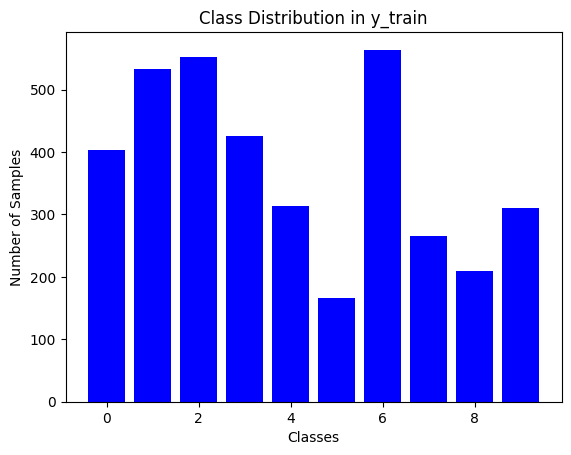

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Encode the labels (y_windows)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_encoded, test_size=0.2, random_state=42)

# Calculate class weights based on the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

unique_classes, class_counts = np.unique(y_train, return_counts=True)

print("Class distribution in y_train:")
for cls, count in zip(unique_classes, class_counts):
  print(f"Class {cls}: {count} samples")

plt.bar(unique_classes, class_counts, color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in y_train')
plt.show()

In [26]:
import kerastuner as kt
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)

X_train, X_test, y_train, y_test = train_test_split(X_windows, y_encoded, test_size=0.3, random_state=42)

# Calculate class weights based on the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define a hypermodel function for Keras Tuner
def build_hypermodel(hp):
    model = Sequential()

    # LSTM Layer 1
    model.add(LSTM(units=hp.Int('units_1', min_value=64, max_value=256, step=64),
                   input_shape=(X_windows.shape[1], X_windows.shape[2]),
                   return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    # LSTM Layer 2
    model.add(LSTM(units=hp.Int('units_2', min_value=64, max_value=256, step=64),
                   return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    # Dense Layer
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                    activation="relu"))

    # Output Layer
    model.add(Dense(len(np.unique(y_encoded)), activation="softmax"))

    # Compile model
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperparam_tuning',
    project_name='lstm_tuning'
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(X_train, y_train, validation_split=0.2, epochs=30, batch_size=64,
             callbacks=[early_stopping], class_weight=class_weights_dict)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
evaluation = best_model.evaluate(X_test, y_test)
print(f"Best model evaluation: {evaluation}")


Trial 20 Complete [00h 02m 51s]
val_accuracy: 0.22560974955558777

Best val_accuracy So Far: 0.333841472864151
Total elapsed time: 00h 28m 48s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
128               |64                |units_1
0.2               |0.3               |dropout_1
128               |192               |units_2
0.4               |0.4               |dropout_2
128               |64                |dense_units
0.0075697         |0.0020576         |learning_rate
4                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/4
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 523ms/step - accuracy: 0.1119 - loss: 2.7425 - val_accuracy: 0.0671 - val_loss: 2.3497
Epoch 2/4
35/41 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - accuracy: 0.1018 - loss: 2.4572

KeyboardInterrupt: 

In [25]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step


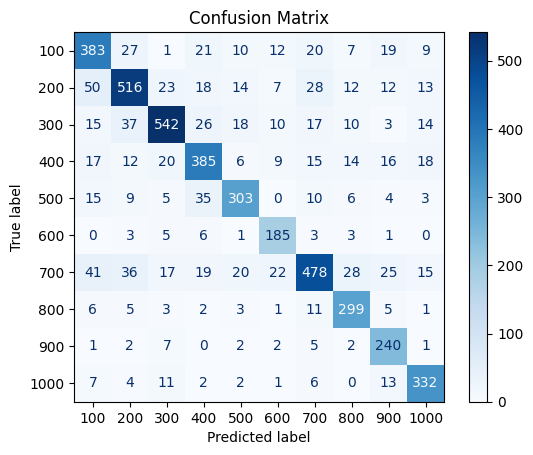

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Make predictions
y_pred_probs = lstm_model.predict(X_windows)  # Predict probabilities for each class
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability

# Step 2: Create the confusion matrix
conf_matrix = confusion_matrix(y_encoded, y_pred)

# Step 3: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()


Text(0.5, 1.0, 'Model loss over Epochs')

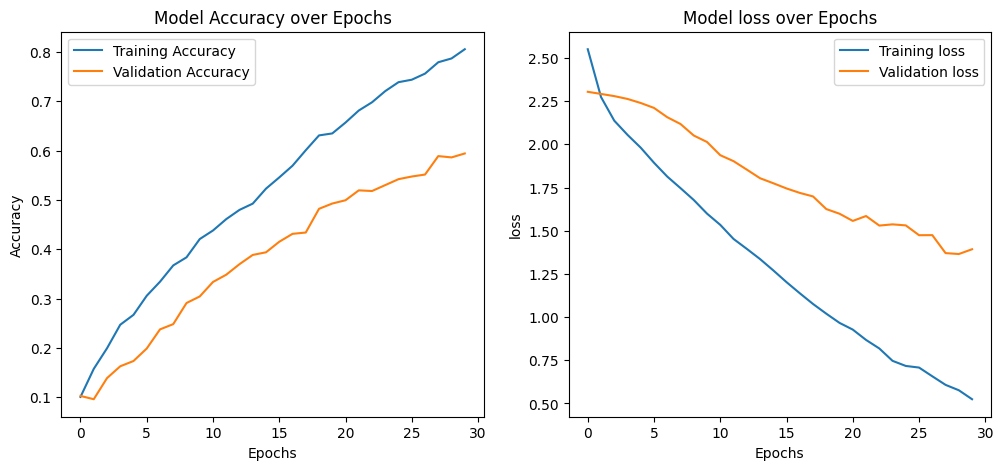

In [16]:
plt.figure(figsize=(12,5))

#Plot model accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy over Epochs')

# Plot model loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Model loss over Epochs')

In [ ]:
from sklearn.metrics import classification_report

y_pred = np.argmax(lstm_model.predict(X_test), axis=1)

target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))


30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step
              precision    recall  f1-score   support

         100       0.82      0.73      0.77       105
         200       0.85      0.68      0.75       160
         300       0.80      0.86      0.83       139
         400       0.79      0.82      0.80        87
         500       0.78      0.83      0.80        76
         600       0.86      0.76      0.81        41
         700       0.71      0.79      0.74       137
         800       0.89      0.79      0.83        70
         900       0.67      0.87      0.75        53
        1000       0.77      0.85      0.81        68

    accuracy                           0.79       936
   macro avg       0.79      0.80      0.79       936
weighted avg       0.79      0.79      0.79       936



In [ ]:
features = lstm_model.predict(X_windows)
print(f"The shape of the features is: {features.shape}")

147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step
The shape of the features is: (4680, 10)


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Assuming 'features' contains the LSTM output for each operation window
# Example of reshaping to prepare features
reshaped_features = y_pred_probs.reshape(y_pred_probs.shape[0], -1)  # Flatten to 2D for similarity

# Calculate semantic similarities to determine the similarity between each feature
similarity_matrix = cosine_similarity(reshaped_features)

sigma=0.99
# Identify top N similar operations for each entry
top_n_similar = 5  # Customize as needed
similar_operations = {}

for idx, similarities in enumerate(similarity_matrix):
    similar_indices = np.argsort(similarities)[-top_n_similar:]  # Top N most similar
    similar_operations[idx] = similar_indices

# Print sample similar operations
print("Sample similar operations based on LSTM features:")
print(similar_operations)

# Particle filter for smoothing transitions
def particle_filter(observed_features, n_particles=500, n_operations=10, resample_threshold=2.0):
    particles = np.random.randint(0, n_operations, size=n_particles)
    weights = np.ones(n_particles) / n_particles # Uniform initial weights
    smoothed_operations = []

    for i in range(len(observed_features)):
        # Random walk and particle update
        particles += np.random.randint(-1, 2, size=n_particles)
        particles = np.clip(particles, 0, n_operations - 1)

        print(f"Iteration {i}: Particle distribution before weight update: {np.bincount(particles, minlength=n_operations)}")


        # Use similarity scores as weights
        #observed_operation = np.argmax(observed_features[i])
        #weights *= (particles == observed_operation)
        similarity = np.exp(-np.abs(particles - np.argmax(observed_features[i]) / sigma)) # sigma to control the "spread" or "sensitivity" of the similarity function while comparing the particles to ovserved_features
        weights *= similarity


        print(f"Iteration {i}: Weights distribution after update: {weights[:10]}")
        #weights_sum = np.sum(weights) + 1e-10 # Normalization of weights after each update.
        #weights /= weights_sum
        weights /= np.sum(weights)

        # Resample if effective number of particles is low
        if 1.0 / np.sum(weights**2) < resample_threshold * n_particles:
            indices = np.random.choice(n_particles, size=n_particles, p=weights)
            particles = particles[indices]
            weights = np.ones(n_particles) / n_particles

        smoothed_operations.append(np.bincount(particles).argmax())

    return np.array(smoothed_operations)


smoothed_operations = particle_filter(y_pred_probs, n_particles=500, n_operations=len(np.unique(y_windows)))

# Result: Smoothed sequence of operations
print("Smoothed operations:", smoothed_operations)

def combined_with_non_numerical(smoothed_operations, unixtime_windows, operation_windows):
  combined_data = []
  min_length = min(len(smoothed_operations), len(unixtime_windows), len(operation_windows))

  for i in range(min_length):
    smoothed_op = smoothed_operations[i]
    unixtime_window = unixtime_windows[i]
    operation_window = operation_windows[i]

    combined_entry = {
        'smoothed_operation': smoothed_op,
        'unixtime_start': unixtime_window[0],
        'unixtime_end': unixtime_window[-1],
        'operation_mode': pd.Series(operation_window).mode()[0]
    }
    combined_data.append(combined_entry)

  return pd.DataFrame(combined_data)

final_output = combined_with_non_numerical(smoothed_operations, unixtime_windows, operation_windows)

final_output['time_spent'] = final_output['unixtime_end'] - final_output['unixtime_start']


Streaming output truncated to the last 5000 lines.
Iteration 3209: Weights distribution after update: [0.00072836 0.0019799  0.00027342 0.00072836 0.00074323 0.00074323
 0.00074323 0.00072836 0.0019799  0.0019799 ]
Iteration 3210: Particle distribution before weight update: [173 172 125  29   1   0   0   0   0   0]
Iteration 3210: Weights distribution after update: [0.00074323 0.00074323 0.00072836 0.00027342 0.00074323 0.00072836
 0.00072836 0.00072836 0.00074323 0.00074323]
Iteration 3211: Particle distribution before weight update: [187 164 122  26   1   0   0   0   0   0]
Iteration 3211: Weights distribution after update: [3.48271554e-05 1.28121945e-05 9.46700236e-05 1.28121945e-05
 1.28121945e-05 9.46700236e-05 3.48271554e-05 9.46700236e-05
 9.46700236e-05 1.28121945e-05]
Iteration 3212: Particle distribution before weight update: [ 65 103 151 129  44   8   0   0   0   0]
Iteration 3212: Weights distribution after update: [0.00074323 0.00027342 0.00074323 0.00074323 0.00027342 0.0

In [ ]:
action_operation_mapping = {
    "Pick Up Sheet": "Picking",
    "Pick Up Item from Box": "Picking",
    "Pick Up Box Sheet": "Picking",
    "Walk to work bench": "Picking",
    "Put Packed Box": "Picking",
    "Remove Item Label": "Relocate Item Label",
    "Write Check Mark": "Relocate Item Label",
    "Put Item Small Bag": "Relocate Item Label",
    "Pick Cardboard": "Assemble Box",
    "Bend Flap": "Assemble Box",
    "Attach Tape": "Assemble Box",
    "Turn Over Box": "Assemble Box",
    "Pick Up Assembled Box": "Assemble Box",
    "Insert Item Into Box": "Insert Items",
    "Separate Air Cushion": "Insert Items",
    "Put Item Small Bag": "Insert Items",
    "Bend Flap": "Close Box",
    "Attach Tape": "Close Box",
    "Attach Box Label": "Attach Box Label",
    "Pick up HT": "Scan Label",
    "Scan Order Sheet": "Scan Label",
    "Scan Box": "Scan Label",
    "Scan Item": "Scan Label",
    "Scan Order Sheet": "Scan Label",
    "Scan Printer": "Scan Label",
    "Pick Up Shipping Label": "Attach Shipping Label",
    "Attach Shipping Label": "Attach Shipping Label",
    "Pick Up Packed Box": "Put on Back Table",
    "Put Packed Box": "Put on Back Table",
    "Pick Up Pen": "Fill out Order",
    "Write Sign": "Fill out Order",
    "Push Order Sheet into Tray": "Fill out Order"
}

final_output["mapped_operation"] = final_output["action_mode"].map(action_operation_mapping)

In [21]:
final_output

,smoothed_operation,unixtime_start,unixtime_end,operation_mode,time_spent
0,0,1634178749767,1634178755138,Picking,5371
1,1,1634178753925,1634178756128,Picking,2203
2,1,1634178755163,1634178757365,Relocate Item Label,2202
3,1,1634178756153,1634178763726,Relocate Item Label,7573
4,2,1634178757390,1634178764964,Relocate Item Label,7574
...,...,...,...,...,...
4675,0,1634180345672,1634180348122,Picking,2450
4676,3,1634180346909,1634180349261,Picking,2352
4677,1,1634180348147,1634180350498,Relocate Item Label,2351
4678,1,1634180349285,1634180351736,Relocate Item Label,2451


In [ ]:
import pandas as pd

df = pd.DataFrame({
    'actual_operations': y_encoded,
    'smoothed_operations': smoothed_operations
})

df['matches'] = df['actual_operations'] == df['smoothed_operations']

accuracy = df['matches'].mean() * 100
print(f"Mapping Accuracy: {accuracy:.2f}%")


mismatches = df[df['matches'] == False]
print("Examples of mismatches:\n", mismatches)

df

Mapping Accuracy: 79.85%
Examples of mismatches:
       actual_operations  smoothed_operations  matches
4                     1                    2    False
8                     2                    3    False
10                    2                    3    False
17                    4                    3    False
23                    4                    3    False
...                 ...                  ...      ...
4671                  0                    3    False
4672                  0                    4    False
4673                  0                    3    False
4674                  0                    1    False
4676                  0                    3    False

[943 rows x 3 columns]


,actual_operations,smoothed_operations,matches
0,0,0,True
1,0,0,True
2,1,1,True
3,1,1,True
4,1,2,False
...,...,...,...
4675,0,0,True
4676,0,3,False
4677,1,1,True
4678,1,1,True


In [ ]:
final_output['unixtime_ISO'] = pd.to_datetime(final_output['time_spent'], unit='s').dt.strftime('%H:%M:%S')

In [ ]:
final_output

,smoothed_operation,unixtime_start,unixtime_end,action_mode,operation_mode,time_spent,unixtime_ISO
0,0,1634178749767,1634178755138,Walk to Work Bench,Picking,5371,01:29:31
1,0,1634178753925,1634178756128,Walk to Work Bench,Picking,2203,00:36:43
2,1,1634178755163,1634178757365,Remove Item Label,Relocate Item Label,2202,00:36:42
3,1,1634178756153,1634178763726,Remove Item Label,Relocate Item Label,7573,02:06:13
4,2,1634178757390,1634178764964,Write Check Mark,Relocate Item Label,7574,02:06:14
...,...,...,...,...,...,...,...
4675,0,1634180345672,1634180348122,Push Order Sheet into Tray,Picking,2450,00:40:50
4676,3,1634180346909,1634180349261,Push Order Sheet into Tray,Picking,2352,00:39:12
4677,1,1634180348147,1634180350498,Push Order Sheet into Tray,Relocate Item Label,2351,00:39:11
4678,3,1634180349285,1634180351736,Push Order Sheet into Tray,Relocate Item Label,2451,00:40:51


In [ ]:
final_output['unixtime_ISO_sec'] = final_output['unixtime_ISO'] .apply(lambda x: pd.to_timedelta(x).total_seconds())

#total_time_per_operation = final_output.groupby('smoothed_operation')['unixtime_ISO'].sum()

average_time_per_operation = final_output['unixtime_ISO_sec'].mean()

mean_time_spent = pd.to_timedelta(average_time_per_operation, unit='s')

print(f"Average time spent:", mean_time_spent)

Average time spent: 0 days 00:45:59.237179487


In [ ]:
#total_time_per_operation = final_output.groupby('smoothed_operation')['time_spent_minutes'].sum()

average_time_per_operation = final_output.groupby('smoothed_operation')['time_spent'].mean()

#print("Total time spent per operation:")
#print(total_time_per_operation)

print("\nAverage time spent per operation:")
print(average_time_per_operation)

average_time_per_operation_minutes = average_time_per_operation / 60

print("\nAverage time spent per operation in minutes:")
print(average_time_per_operation_minutes)


Average time spent per operation:
smoothed_operation
0    14389.671533
1     7606.741692
2     9043.763298
3     2691.216814
4     2690.839130
5     2551.163077
6     2849.543089
7     2671.090909
8     2818.003165
9     2586.060000
Name: time_spent, dtype: float64

Average time spent per operation in minutes:
smoothed_operation
0    239.827859
1    126.779028
2    150.729388
3     44.853614
4     44.847319
5     42.519385
6     47.492385
7     44.518182
8     46.966719
9     43.101000
Name: time_spent, dtype: float64


In [ ]:
negative_time_spent = final_output[final_output['time_spent'] < 0]
print("Rows with negative 'time_spent' values:")
print(negative_time_spent)

final_output['time_spent'] = final_output['time_spent'].abs()

NameError: name 'final_output' is not defined

In [ ]:
operation_mapping = final_output.groupby('smoothed_operation').agg(
    most_common_operation_mode = ('operation_mode', lambda x: x.mode()[0])
).reset_index()

print(operation_mapping)

   smoothed_operation most_common_operation_mode
0                   0                    Picking
1                   1        Relocate Item Label
2                   2               Assemble Box
3                   3               Insert Items
4                   4                  Close Box
5                   5           Attach Box Label
6                   6                 Scan Label
7                   7      Attach Shipping Label
8                   8          Put on Back Table
9                   9             Fill out Order


In [22]:
operation_mapping = final_output.groupby('smoothed_operation').agg(
    most_common_operation_mode = ('operation_mode', lambda x: x.mode()[0])
).reset_index()

print(operation_mapping)

   smoothed_operation most_common_operation_mode
0                   0                    Picking
1                   1        Relocate Item Label
2                   2               Assemble Box
3                   3               Insert Items
4                   4                  Close Box
5                   5           Attach Box Label
6                   6                 Scan Label
7                   7      Attach Shipping Label
8                   8          Put on Back Table
9                   9             Fill out Order


In [ ]:
final_output['unixtime_start'] = pd.to_datetime(final_output['unixtime_start'], unit='ms')
final_output['unixtime_end'] = pd.to_datetime(final_output['unixtime_end'], unit='ms')

operation_times = final_output.groupby('smoothed_operation').agg(
    start_time = ('unixtime_start', 'min'),
    end_time = ('unixtime_end', max),
    total_time_spent = ('time_spent', 'sum')
).reset_index()

operation_times['average_time_per_operation'] = operation_times['total_time_spent'] / 60
print(operation_times[['smoothed_operation', 'average_time_per_operation']])

   smoothed_operation  average_time_per_operation
0                   0               -20980.833333
1                   1               -26005.966667
2                   2               -43483.183333
3                   3                27949.266667
4                   4                20724.566667
5                   5                12280.466667
6                   6                33446.616667
7                   7                15951.216667
8                   8                15354.966667
9                   9                15823.383333


<ipython-input-16-f9d4ea60d783>:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  operation_times = final_output.groupby('smoothed_operation').agg(


In [ ]:
df

,Unnamed: 0,acc_x/atr01,acc_y/atr01,acc_z/atr01,gyro_x/atr01,gyro_y/atr01,gyro_z/atr01,quat_w/atr01,quat_x/atr01,quat_y/atr01,...,gyro_z/atr04,quat_w/atr04,quat_x/atr04,quat_y/atr04,quat_z/atr04,unixtime,operation,operation_id,operation_box,action
0,0,0.2838,0.9830,0.0572,-3.21,127.65,7.39,0.0,0.0,0.0,...,15.84,0.0,0.0,0.0,0.0,1634178749767,Picking,100,5,Pick Up Sheet
1,1,0.6522,0.5233,-0.1144,20.48,-128.33,20.63,0.0,0.0,0.0,...,-4.77,0.0,0.0,0.0,0.0,1634178752712,Picking,100,5,Walk to Work Bench
2,2,0.8885,0.5363,-0.2540,14.25,-36.07,4.55,0.0,0.0,0.0,...,-4.14,0.0,0.0,0.0,0.0,1634178752737,Picking,100,5,Walk to Work Bench
3,3,0.7325,0.5607,-0.2147,15.04,41.69,-1.06,0.0,0.0,0.0,...,-3.66,0.0,0.0,0.0,0.0,1634178752762,Picking,100,5,Walk to Work Bench
4,4,0.6881,0.6066,-0.2313,19.58,23.04,-6.57,0.0,0.0,0.0,...,-5.29,0.0,0.0,0.0,0.0,1634178752787,Picking,100,5,Walk to Work Bench
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234055,236934,0.5821,0.6215,0.3789,57.09,16.70,-16.06,0.0,0.0,0.0,...,4.75,0.0,0.0,0.0,0.0,1634180353122,Relocate Item Label,200,20,Push Order Sheet into Tray
234056,236935,0.4930,0.7413,0.3516,68.20,-17.90,-31.30,0.0,0.0,0.0,...,-3.57,0.0,0.0,0.0,0.0,1634180353146,Relocate Item Label,200,20,Push Order Sheet into Tray
234057,236936,0.3956,0.8500,0.3926,75.23,-85.26,-46.44,0.0,0.0,0.0,...,-12.15,0.0,0.0,0.0,0.0,1634180353171,Relocate Item Label,200,20,Push Order Sheet into Tray
234058,236937,0.3392,0.9152,0.3362,75.68,-175.34,-61.53,0.0,0.0,0.0,...,-16.72,0.0,0.0,0.0,0.0,1634180353196,Relocate Item Label,200,20,Push Order Sheet into Tray


In [ ]:
df['unixtime'] = pd.to_datetime(df['unixtime'], unit='ms')
final_output['unixtime_start'] = pd.to_datetime(final_output['unixtime_start'], unit='ms')
final_output['unixtime_end'] = pd.to_datetime(final_output['unixtime_end'], unit='ms')

plt.figure(figsize=(14, 8))
plt.plot(df['unixtime'], df['operation_id'], label = "Operation id", color='blue', alpha=0.7)
plt.plot(final_output['unixtime_start'], final_output['smoothed_operation'], label = "Smoothed operation", color='red', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Operation ID')
plt.title('Operation ID over time')
plt.legend()
plt.show()

NameError: name 'pd' is not defined